<a href="https://colab.research.google.com/github/vishkaush/misc-projects/blob/main/Shallow_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [105]:
import numpy as np
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

X's shape =  (2, 400)
y's shape =  (1, 400)


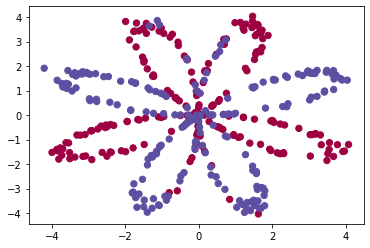

In [106]:
X, y = load_planar_dataset()
print("X's shape = ", X.shape)
print("y's shape = ", y.shape)
import matplotlib.pyplot as plt
plt.scatter(X[0,:], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)

# Logistic Regression (sklearn)

In [107]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, y.T)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [108]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Train accuracy 1 of logistic regression: 47 % (percentage of correctly labelled datapoints)
Alternative computation that will work if the datatypes are integers:  47.0


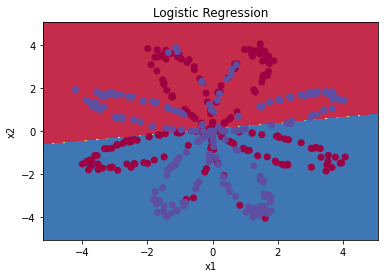

In [109]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)   #(400,)
y_predict = LR_predictions.reshape(y.shape)
print ('Train accuracy 1 of logistic regression: %d ' % float((np.dot(y,LR_predictions) + np.dot(1-y,1-LR_predictions))/float(y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")
y_predict = y_predict.astype(np.int32)
yint = y.astype(np.int32)
print ('Alternative computation that will work if the datatypes are integers: ', (100 - (np.mean(np.abs(yint - y_predict)) * 100)))

# One Hidden Layer Neural Network

In [110]:
def sigmoid(x):
  s = 1/(1+np.exp(-x))
  return s

In [111]:
def layer_sizes(X, y, num_hidden) :
  n_x = X.shape[0] # no. of nodes in input layer
  n_h = num_hidden # no. of nodes in hidden layer
  n_y = y.shape[0] # no. of nodes in output layer
  return (n_x, n_h, n_y)

In [112]:
def initialize_params(n_x, n_h, n_y):
  np.random.seed(2)
  W1 = np.random.rand(n_h, n_x) * 0.01
  W2 = np.random.randn(n_y, n_h) * 0.01
  b1 = np.zeros((n_h, 1))
  b2 = np.zeros((n_y, 1))
  params = {"W1": W1,
            "W2": W2,
            "b1": b1,
            "b2": b2}
  return params

In [113]:
def forward_propagation(X, params):
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2)
  assert(A2.shape == (1, X.shape[1]))
  cache = {"Z1": Z1,
           "A1": A1,
           "Z2": Z2,
           "A2": A2}
  return A2, cache

In [114]:
def compute_cost(A2, y):
  m = y.shape[1]
  logprobs = np.multiply(np.log(A2),y)+np.multiply((1-y),np.log(1-A2))
  cost = -(1/m)*np.sum(logprobs)
  assert(isinstance(cost, float))
  return cost

In [115]:
def backward_propagation(params, cache, X, y):
  m = X.shape[1]
  W1 = params["W1"]
  W2 = params["W2"]
  A1 = cache["A1"]
  A2 = cache["A2"]
  dZ2 = (A2 - y)
  dW2 = ((1/m)*np.dot(dZ2,A1.T))
  db2 = ((1/m)*np.sum(dZ2,axis=1,keepdims = True))
  dZ1 = dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
  dW1 = ((1/m)*np.dot(dZ1,X.T))
  db1 = ((1/m)*np.sum(dZ1,axis=1,keepdims = True))
  grads = {"dW1": dW1,
           "db1": db1,
           "dW2": dW2,
           "db2": db2 }
  return grads

In [116]:
def update_params(params, grads, learning_rate):
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  dW1 = grads["dW1"]
  db1 = grads["db1"]
  dW2 = grads["dW2"]
  db2 = grads["db2"]
  W1 = W1-learning_rate*dW1
  b1 = b1-learning_rate*db1
  W2 = W2-learning_rate*dW2
  b2 = b2-learning_rate*db2
  params = {"W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2}
    
  return params


In [117]:
def predict(params, X):
  A2, _ = forward_propagation(X, params)
  predictions = np.where(A2 > 0.5, 1.0, 0.0)
  return predictions

In [125]:
def nn_model(X, y, num_hidden, num_iterations, learning_rate, accuracyEveryN=None):
    n_x, n_h, n_y = layer_sizes(X, y, num_hidden)
    params = initialize_params(n_x, n_h, n_y)
    costs = []
    train_accuracies = []
    for i in range(num_iterations):
      A2, cache = forward_propagation(X, params)
      cost = compute_cost(A2, y)
      costs.append(cost)
      grads = backward_propagation(params, cache, X, y)
      params = update_params(params, grads, learning_rate)
      if accuracyEveryN is not None and i%accuracyEveryN==0:
        y_prediction = predict(params, X)
        train_accuracy = float((np.dot(y,y_prediction.T) + np.dot(1-y,(1-y_prediction).T))/float(y.size)*100)
        train_accuracies.append(train_accuracy)
    return costs, train_accuracies, params

In [126]:
costs, train_accuracies, params = nn_model(X, y, 4, 10000, 1.2, 500)

In [127]:
predictions = predict(params, X)
print ('Final accuracy: %d' % float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100) + '%')

Final accuracy: 91%


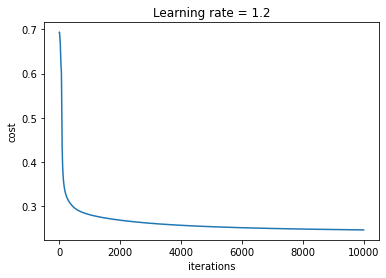

In [128]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate = 1.2")
plt.show()

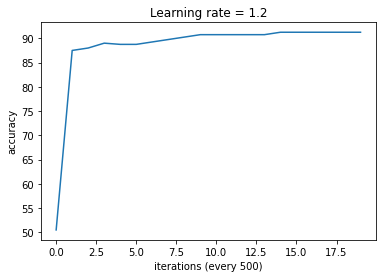

In [129]:
plt.plot(train_accuracies)
plt.ylabel('accuracy')
plt.xlabel('iterations (every 500)')
plt.title("Learning rate = 1.2")
plt.show()

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

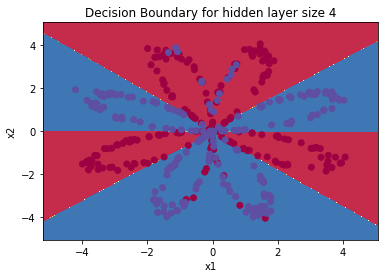

In [130]:
plot_decision_boundary(lambda x: predict(params, x.T), X, y)
plt.title("Decision Boundary for hidden layer size " + str(4))

## Effect of number of hidden nodes

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.75 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.5 %
Accuracy for 50 hidden units: 91.0 %


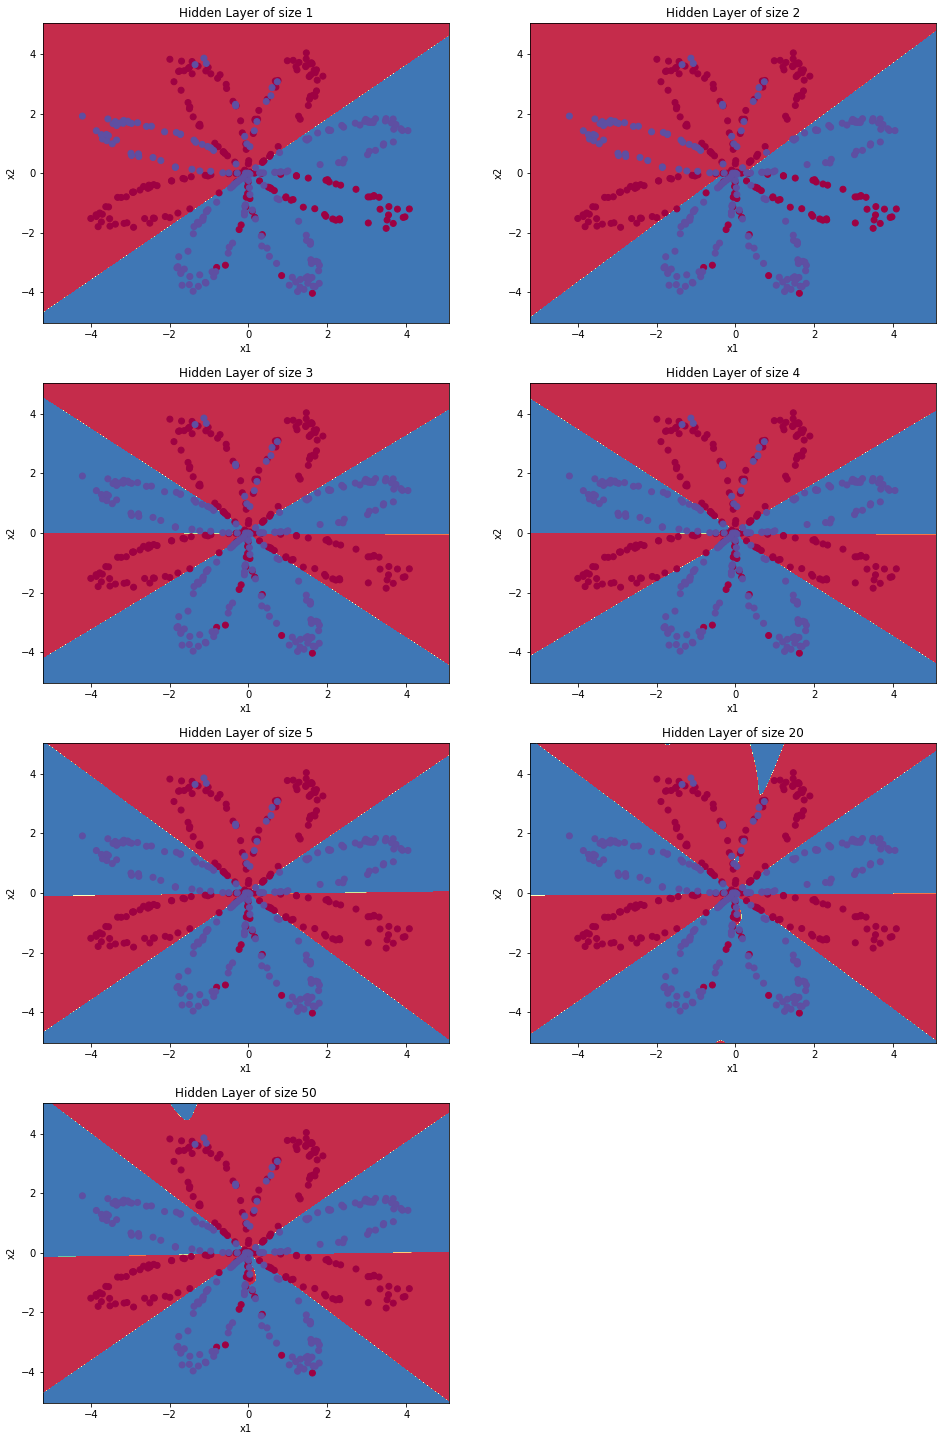

In [132]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    costs, train_accuracies, params = nn_model(X, y, n_h, 5000, 1.2)
    plot_decision_boundary(lambda x: predict(params, x.T), X, y)
    predictions = predict(params, X)
    accuracy = float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))